# Prospecção de Dados (Data Mining) DI/FCUL - HA2

## Second Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`02`

* João Martins, 62532 - Hours worked on the project: 8k
* Rúben Torres, 62531 - Hours worked on the project: 8k
* Nuno Pereira, 56933 - Hours worked on the project: 8k



## Objectives
The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Process and identify the most relevant rules

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


### 1. Read the Dataset

Dataset: Instacart [Market Basket Analysis](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis)



The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Identify the most relevant rules

Please download the HA files from this moodle folder and inspect it like this:

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

The dataset has been preprocessed with transactions as lists of integers. It is necessary a decoder to see the actual products bought together

Uncompress the data set (zip file) which will produce 2 files:
* `order_products.pickle` a Python pickle with all the trasactions
* A `products.txt` - decoder table with all the data relative to each item



In [4]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    
#read transactions
import pickle
orders=pickle.load(open("order_products.pickle", "rb"))

#check names of products on transaction 2 (example):
print("Transaction 2 is", orders[2])
for prod in orders[2]: print("Code: %5d is product: %s" %(prod, products[prod]))

Transaction 2 is [33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668]
Code: 33120 is product: Organic Egg Whites
Code: 28985 is product: Michigan Organic Kale
Code:  9327 is product: Garlic Powder
Code: 45918 is product: Coconut Butter
Code: 30035 is product: Natural Sweetener
Code: 17794 is product: Carrots
Code: 40141 is product: Original Unflavored Gelatine Mix
Code:  1819 is product: All Natural No Stir Creamy Almond Butter
Code: 43668 is product: Classic Blend Cole Slaw


### Objective 1 - Analyze the itemset/rules generation procedure

1. From the approaches used in classes make a performance analysis up to a threshold level of support
2. Define a good support threshold for analysis according to your computational capabilities


In [5]:
### Add supporting functions here
from scipy.sparse import csr_matrix
from IPython.display import display_html
from itertools import chain,cycle

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
from pyfim import pyeclat
from PD_freqitems import freqitemsets

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


def display_side_by_side(*args,titles=cycle([''])) -> None:
    html_str: str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

def plot_execution_time(Dict: dict) -> None:
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["apriori"]), c="r", label="apriori")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["FP-growth"]), c="k", label="fp-growth")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["ECLAT"]), c="g", label="eclat")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["PD"]), c="b", label="PD")
    plt.grid()
    plt.legend()
    plt.show()

def compute_binary_encoder(products, orders) -> pd:
    tr_enc = TransactionEncoder()
    trans_array = tr_enc.fit_transform(orders.values(), sparse=True)
    trans_array = csr_matrix(trans_array, shape=(len(orders.values()), len(tr_enc.columns_)))

    products_list = []
    for i in range(len(tr_enc.columns_)+1):
        products_list.append(products[i])

    products_list.pop(0)
    return pd.DataFrame.sparse.from_spmatrix(trans_array, columns=products_list)


################################################################
# Compute binary database
def test_minimum_support(binary_database: pd, Dict: dict) -> dict:
    for min_supp in Dict["threshold"]:
        t0 = time.time()
        FI_apriori=apriori(binary_database, min_supp)
        t1 = time.time()
        
        Dict["num_itemsets"].append(FI_apriori.shape[0])
        Dict["apriori"].append(t1-t0)

        FI_fpg= fpgrowth(binary_database, min_supp)
        t2 = time.time()

        Dict["FP-growth"].append(t2-t1)

        FI_eclat= pyeclat(orders.values(), min_supp)
        t3 = time.time()
        Dict["ECLAT"].append(t3-t2)

        FI_pdfis= freqitemsets(orders.values(), min_supp)
        t4 = time.time()
        Dict["PD"].append(t4-t3)

        print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0,
                                            "\n\tFP-growth time:", t2-t1,
                                            "\n\tECLAT time:", t3-t2,
                                            "\n\tPD time:", t4-t3)
    return Dict

########################################################################################################
# MemoryError: Unable to allocate 149. GiB for an array with shape (3214874, 49677) and data type bool #
########################################################################################################

# binary_database = compute_binary_encoder(products, orders)
# binary_database 

C:\Users\joaom\AppData\Local\Temp\ipykernel_10164\3173793044.py:45: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  return pd.DataFrame.sparse.from_spmatrix(trans_array, columns=products_list)


0.09 2 
	Apriori time: 1.0774493217468262 
	FP-growth time: 8.94369387626648 
	ECLAT time: 46.03245687484741 
	PD time: 22.58569073677063
0.05 6 
	Apriori time: 1.294785976409912 
	FP-growth time: 9.435704946517944 
	ECLAT time: 44.74222683906555 
	PD time: 22.01999068260193
0.02 39 
	Apriori time: 13.196900606155396 
	FP-growth time: 13.507108688354492 
	ECLAT time: 51.46395421028137 
	PD time: 30.613744735717773
0.015 69 
	Apriori time: 118.02904391288757 
	FP-growth time: 23.64896035194397 
	ECLAT time: 59.40992999076843 
	PD time: 40.03378629684448


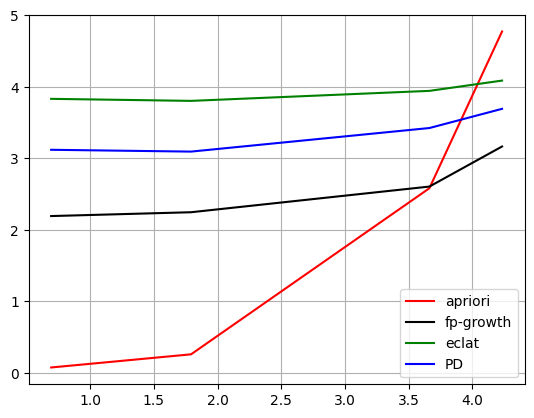

In [6]:
### Add processing code here
### 9 min execution

binary_database = compute_binary_encoder(products, orders)

FI_apriori = apriori(binary_database, min_support=0.02, use_colnames=False)
FI_apriori_len = FI_apriori.copy()

FI_apriori_len['length'] = FI_apriori_len['itemsets'].apply(lambda x: len(x))
FI_apriori_len = FI_apriori_len.sort_values(by=['length'], ascending=False)


FI_fpg = fpgrowth(binary_database, min_support=0.02, use_colnames=False)
FI_fpg

FI_fpg['length'] = FI_fpg['itemsets'].apply(lambda x: len(x))
FI_fpg.sort_values(by=['length'], ascending=False)

FI_eclat = pyeclat(orders.values(), supp=0.02)
FI_eclat

FI_FI_fpg_filtered = FI_fpg[(FI_fpg['support'] >= 0.01) & (FI_fpg['length'] >= 2)]
FI_FI_fpg_filtered


# display_side_by_side(FI_apriori, FI_fpg, FI_eclat)




Dict={"threshold": [0.09, 0.05, 0.02, 0.015], # 0.01
"num_itemsets": [],
"apriori":[],
"FP-growth": [],
"ECLAT": [],
"PD": []}

#WARNING! 0.01 sometimes crashes my computer it may well crash yours!

Dict = test_minimum_support(binary_database, Dict)

df_performance=pd.DataFrame(Dict)
df_performance

plot_execution_time(Dict)

### Your short analysis here

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Objective 2 - Identify the most relevant rules

1. From your predefined support level generate all available itemsets and generate rules
2. Identify a set of 10 relevant rules using the Highest Lift criterion
    * **NOTE**: Present the rules with the product names and not as Integers 
3. Identify the Maximal and Closed Itemsets for the same level of support and generate 5 rules using the Highest Lift
    * **NOTE**: Do not list the Maximal or Closed Itemsets. Present just a few as an example and mention **how many** Closed and Maximal Itemsets were found for the selected support level
    * **NOTE**: Present the rules with the product names and not as Integers 


In [10]:
### Add supporting functions here
###  min execution

from mlxtend.frequent_patterns import association_rules, fpmax

FI_apriori = apriori(binary_database, min_support=0.011, use_colnames=False)
FI_apriori_len = FI_apriori.copy()

FI_apriori_len['length'] = FI_apriori_len['itemsets'].apply(lambda x: len(x))
FI_apriori_len = FI_apriori_len.sort_values(by=['length'], ascending=False)

print(FI_apriori_len)

all_rules = association_rules(df=FI_apriori_len, metric="confidence", min_threshold=0.05)
all_rules


# FI_fpmax=fpmax(binary_database, min_support=0.05, use_colnames=False)
# FI_fpmax


# Trans_maximal = pyeclat(orders.values(), 0.05, target="m")
# print("Number of Maximal Itemsets", len(Trans_maximal))
# Trans_maximal


# Trans_closed = pyeclat(binary_database, 0.05, target="c")
# print("Number of Closed Itemsets", len(Trans_closed))
# Trans_closed

# display_side_by_side(all_rules, FI_fpmax, Trans_maximal, Trans_closed)


      support        itemsets  length
104  0.016609  (24848, 47755)       2
99   0.011862  (21899, 21133)       2
94   0.019170  (13172, 21133)       2
96   0.012599  (27960, 13172)       2
97   0.019391  (13172, 47198)       2
..        ...             ...     ...
32   0.017259         (21934)       1
31   0.075251         (21899)       1
30   0.022654         (21612)       1
29   0.082331         (21133)       1
52   0.027880         (28198)       1

[105 rows x 3 columns]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24848),(47755),0.146993,0.054999,0.016609,0.112990,2.054395,0.008524,1.065378,0.601682
1,(47755),(24848),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109
2,(21899),(21133),0.075251,0.082331,0.011862,0.157630,1.914594,0.005666,1.089390,0.516568
3,(21133),(21899),0.082331,0.075251,0.011862,0.144074,1.914594,0.005666,1.080408,0.520554
4,(13172),(21133),0.118030,0.082331,0.019170,0.162414,1.972702,0.009452,1.095612,0.559067
5,(21133),(13172),0.082331,0.118030,0.019170,0.232837,1.972702,0.009452,1.149652,0.537319
6,(27960),(13172),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
7,(13172),(27960),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
8,(13172),(47198),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
9,(47198),(13172),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011


In [8]:

FI_fpmax = fpmax(binary_database, min_support=0.05, use_colnames=False)
FI_fpmax

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24848),(47755),0.146993,0.054999,0.016609,0.112990,2.054395,0.008524,1.065378,0.601682
1,(47755),(24848),0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042,0.543109
2,(24848),(21899),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180
3,(21899),(24848),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
4,(24848),(21133),0.146993,0.082331,0.017468,0.118832,1.443353,0.005365,1.041424,0.360101
5,(21133),(24848),0.082331,0.146993,0.017468,0.212163,1.443353,0.005365,1.082720,0.334727
6,(13172),(47198),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
7,(47198),(13172),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
8,(21899),(13172),0.075251,0.118030,0.015668,0.208217,1.764107,0.006787,1.113904,0.468388
9,(13172),(21899),0.118030,0.075251,0.015668,0.132750,1.764107,0.006787,1.066301,0.491106


In [9]:
Trans_maximal = pyeclat(orders.values(), 0.05, target="m")
print("Number of Maximal Itemsets", len(Trans_maximal))
Trans_maximal

NameError: name 'FI_fpmax' is not defined

In [ ]:
Trans_maximal

,support,itemsets
0,0.054999,"(47766,)"
1,0.066436,"(47209,)"
2,0.075251,"(21903,)"
3,0.082331,"(21137,)"
4,0.118030,"(13176,)"
5,0.146993,"(24852,)"


In [ ]:
Trans_closed = pyeclat(binary_database, 0.05, target="c")
print("Number of Closed Itemsets", len(Trans_closed))
Trans_closed

,support,itemsets
0,0.050889,"(-, i, e, )"
1,0.050929,"(-, i, e)"
2,0.052600,"(-, i, )"
3,0.052660,"(-, i)"
4,0.050385,"(-, r, a, )"
...,...,...
142209,0.903658,"(a, )"
142210,0.911408,"(a,)"
142211,0.926002,"(e, )"
142212,0.933390,"(e,)"


In [ ]:
closed_itemsets = association_rules(Trans_closed, metric="support", min_threshold=0.8, support_only=True)
maximal_itemsets = association_rules(Trans_maximal, metric="support", min_threshold=0.8, support_only=False)

print(closed_itemsets)
print(maximal_itemsets)

   antecedents consequents  antecedent support  consequent support   support  \
0          ( )         (i)                 NaN                 NaN  0.821004   
1          (i)         ( )                 NaN                 NaN  0.821004   
2          ( )         (r)                 NaN                 NaN  0.834974   
3          (r)         ( )                 NaN                 NaN  0.834974   
4       ( , e)         (a)                 NaN                 NaN  0.850937   
5       ( , a)         (e)                 NaN                 NaN  0.850937   
6       (e, a)         ( )                 NaN                 NaN  0.850937   
7          ( )      (e, a)                 NaN                 NaN  0.850937   
8          (e)      ( , a)                 NaN                 NaN  0.850937   
9          (a)      ( , e)                 NaN                 NaN  0.850937   
10         (e)         (a)                 NaN                 NaN  0.855144   
11         (a)         (e)              

In [ ]:
### Add processing code here

#generated by using ChatGPT
# Get closed and maximal itemsets using association_rules
closed_itemsets = association_rules(Trans_closed, metric="support", min_threshold=0.02, support_only=True)
maximal_itemsets = association_rules(Trans_maximal, metric="support", min_threshold=0.02, support_only=False)

#generated by using ChatGPT
rules_closed = association_rules(closed_itemsets, metric="lift", min_threshold=1)
rules_maximal = association_rules(maximal_itemsets, metric="confidence", min_threshold=0.2)

#generated by using ChatGPT
# Sort the rules by confidence and Lift
rules_closed = rules_closed.sort_values(["confidence", "lift"], ascending=[False, False])
rules_maximal = rules_maximal.sort_values(["confidence", "lift"], ascending=[False, False])

# Filter the rules with minimum confidence and Lift
min_confidence = 0.8
min_lift = 1.5
rules_closed = rules_closed[(rules_closed["confidence"] >= min_confidence) & (rules_closed["lift"] >= min_lift) ]
rules_maximal = rules_maximal[(rules_maximal["confidence"] >= min_confidence) & (rules_maximal["lift"] >= min_lift)]

print(rules_closed)
print(rules_maximal)

KeyboardInterrupt: 

### Your short analysis here

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
